# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import json
from pandas.io.json import json_normalize
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Data Preview

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Data Cleaning

## 1. Profile

In this section, I converted the column 'became_member_on' to an actual datetime column, as well as removed all null rows from the dataframe.

In [5]:
# Convert to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [6]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [7]:
profile.dropna(axis=0, how='any', inplace=True)

In [8]:
# cleaned version of profile
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


## 2. Transcript

This section contains a single column called 'Value' that actually contains three separate labels: offer id, amount and reward in the form of a dictionary. Therefore, I transformed the dictionary values into three separate columns.

In [9]:
trans_value = transcript['value']
trans_value.head()
# the last column of 'transcipt' is actually a dictionary, so the following function would transform
# dictionary values into columns

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [10]:
trans_value = json_normalize(trans_value)
# trans_value now consists of four columns: amount, reward, offer id and offer_id

In [11]:
trans_value.drop(columns=['amount', 'reward'], inplace=True)

In [12]:
trans_value.fillna(value='', inplace=True)

In [13]:
offer_id1 = trans_value['offer id']

In [14]:
offer_id2 = trans_value['offer_id']

In [15]:
offer_id = offer_id1 + offer_id2
# extracting both columns and concatenating them together

In [16]:
offer_id = pd.DataFrame(data=offer_id)

In [17]:
offer_id.replace(to_replace='', value='NaN', inplace=True)

In [18]:
trans_value = json_normalize(transcript['value'])

In [19]:
trans_value.drop(columns=['offer id', 'offer_id'], inplace=True)

In [20]:
trans_value['offer id'] = offer_id

In [21]:
transcript.drop(columns='value', inplace=True)

In [22]:
transcript = pd.concat([transcript, trans_value], axis=1)

In [23]:
transcript.head()
# transcript dataframe with amount, reward and offer id instead of value.

,event,person,time,amount,reward,offer id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [24]:
# Drop transaction rows whose person(customer_id) is not in profile customer id
transcript = transcript[transcript.person.isin(profile.id)]

In [25]:
transcript.drop_duplicates(inplace=True)

## 3. Portfolio

In this section, i performed one-hot encoding to all needed columns so that the data could be used easily later on.

In [26]:
# Add in the email, mobile, social, and web columns
channels = ['email', 'web', 'mobile', 'social'] 

for channel in channels: 
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

portfolio.drop('channels', axis = 1, inplace=True) # No longer need the channels column

offertypes = ['bogo', 'discount', 'informational']

for offertype in offertypes: 
    portfolio[offertype] = portfolio['offer_type'].apply(lambda x: 1 if offertype in x else 0)

portfolio.drop('offer_type', axis = 1, inplace=True) # No longer need the offer_type column

# Make Sure all of the int and float columns are correct
cols_to_update = ['difficulty', 'duration','reward']

for col in cols_to_update: portfolio[col] = portfolio[col].apply(lambda x: int(x))

In [27]:
portfolio.head()

,difficulty,duration,id,reward,email,web,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


# Cleaned Data Overview

Here is an overview of the cleaned version of the previous dataframes.

In [28]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [29]:
transcript.head()

,event,person,time,amount,reward,offer id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [30]:
portfolio.head()

,difficulty,duration,id,reward,email,web,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


# Data Analysis

Here I explored the data and plotted histograms that showed various relations between attributes.

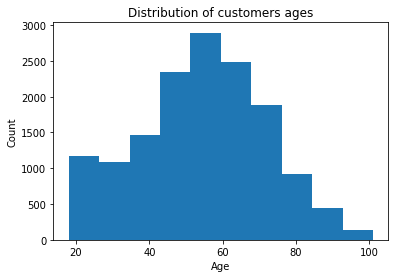

In [31]:
# Visualize age distribution
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of customers ages');

In [32]:
profile['start_year'] = profile['became_member_on'].dt.year

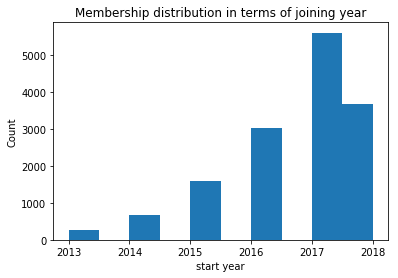

In [33]:
# Visualize the start year distribution
plt.hist(profile['start_year'])
plt.xlabel('start year')
plt.ylabel('Count')
plt.title('Membership distribution in terms of joining year');

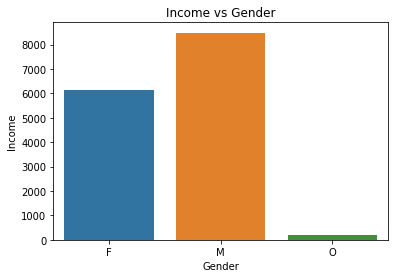

In [34]:
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

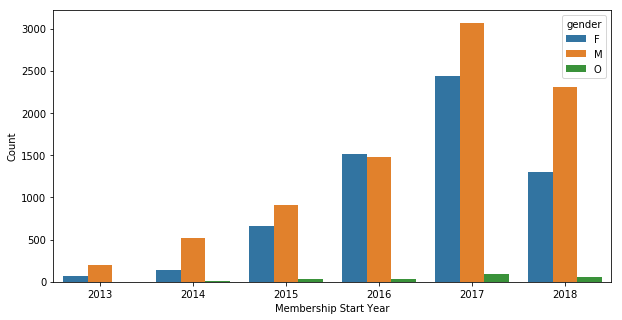

In [35]:
# groupby start_year and gender to plot a graph
membership_date = profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

In [36]:
df = pd.merge(transcript, profile, left_on= 'person', right_on= 'id', how='inner')

In [37]:
df.dropna(subset=['offer id'] ,inplace=True)

In [38]:
df.amount.fillna(0 , inplace=True)

In [39]:
df = df.merge(portfolio , left_on='offer id' , right_on='id'  ,how='left')

# Data Preparation

In this section I combined the three main dataframes into one large dataframe to prepare it for the model. I also filled all NaN values with zero to ensure compatibility and removed duplicate columns.

In [40]:
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')

In [41]:
df.rename(columns={'person': 'customer_id'}, inplace=True)

In [42]:
df['year'] = df.became_member_on.dt.year
df['month'] = df.became_member_on.dt.month

In [43]:
df.drop(columns=['id_x', 'offer id','customer_id','became_member_on','id_y', 'reward_y', 'start_year'], inplace= True)

In [44]:
# Convert gender values to numeric 0s and 1s
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [45]:
df['received'] = df.event.apply(lambda x: 1 if x == 'offer received' else 0)
df['completed'] = df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
df['viewed'] = df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

df.drop(columns=['event', 'amount'], inplace=True)

In [46]:
df.fillna(0, inplace=True)

In [47]:
cols_to_update = ['difficulty', 'duration','reward_x']

for col in cols_to_update: df[col] = df[col].apply(lambda x: int(x))

In [48]:
df.dtypes

time               int64
reward_x           int64
age                int64
gender             int64
income           float64
difficulty         int64
duration           int64
email            float64
web              float64
mobile           float64
social           float64
bogo             float64
discount         float64
informational    float64
year               int64
month              int64
received           int64
completed          int64
viewed             int64
dtype: object

In [49]:
df

,time,reward_x,age,gender,income,difficulty,duration,email,web,mobile,social,bogo,discount,informational,year,month,received,completed,viewed
0,0,0,75,0,100000.0,5,7,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2017,5,1,0,0
1,6,0,75,0,100000.0,5,7,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2017,5,0,0,1
2,132,0,75,0,100000.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,5,0,0,0
3,132,5,75,0,100000.0,5,7,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2017,5,0,1,0
4,144,0,75,0,100000.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,5,0,0,0
5,168,0,75,0,100000.0,0,3,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2017,5,1,0,0
6,216,0,75,0,100000.0,0,3,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2017,5,0,0,1
7,222,0,75,0,100000.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,5,0,0,0
8,240,0,75,0,100000.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,5,0,0,0
9,378,0,75,0,100000.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,5,0,0,0


# Modeling
In this section, I will build a model that predicts whether or not a person is likely to complete an offer.
In the first step I will split the data into training and testing. Next, I will use AdaBoostClassifier to train the model. Finally, I will display the prediction.

In [50]:
# splitting data into training and testing
feature_cols = df.drop(['completed'], axis = 1).columns
X = df[feature_cols]
y = df.completed

# split the data into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(190671, 18)

(81717, 18)

(190671,)

(81717,)

In [51]:
classifier = AdaBoostClassifier()
model = classifier.fit(X_train,y_train)

In [52]:
y_pred = model.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred)

1.0

In [54]:
f1_score(y_test, y_pred)

1.0

# Results
The Model was able to accurately predict whether or not a person will complete an offer, with an accuracy score and f1 score of 100%. 
Since the problem is a classification problem, Accuracy was the best metric 

# Discussion and Conclusion

In this project I attempted to answer the question of how likely a person is to complete an offer. To achieve this, first I needed to clean the data. This was done by removing null values of income and gender in the profile dataset, then transforming the 'value' column in transcript to the values of its dictionary. 

In addition i one-hot encoded the channels and offer types. After the cleaning procedure I explored the data set by plotting histograms. 

Afterwards I combined all three dataframes into one and filled all null values with zero. 

Finally, I built my model and predicted whether or not a person is likely to complete an offer. 